In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
import os
import re
import codecs
from IPython.display import display, Math
from IPython.display import Image as ipImage
from six.moves import cPickle as pickle
import string
from PIL import Image
import numpy as np
import h5py
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [3]:
width = None
pd.options.display.max_rows = 200
pd.options.display.max_columns = width
pd.options.display.max_colwidth = -1
pd.options.display.width = -1
pd.options.display.max_seq_items = None
pd.options.display.expand_frame_repr = False
pd.options.display.colheader_justify = 'left'

In [4]:
import data_commons as dtc
import dl_commons as dlc
import viz_commons as vc
from viz_commons import VisualizeDir, DiffParams, VisualizeStep

Using TensorFlow backend.


In [5]:
# vd = VisualizeDir(os.path.expanduser('/zpool_3TB/i2l/tb_metrics/2017-12-21 02-20-10 PST 140K_score_89.0/store'))
# vd = VisualizeDir(os.path.expanduser('/zpool_3TB/i2l/tb_metrics/2017-12-25 21-04-15 PST 140K_noRegroup_score89.09/store_2'))
# vd = VisualizeDir(os.path.expanduser('/zpool_3TB/i2l/tb_metrics/2017-12-16 18-51-38 PST pLambda=0_score_88.86/store'))
vd = VisualizeDir(os.path.expanduser('/zpool_3TB/i2l/tb_metrics/2017-12-25 21-04-15 PST 140K_noRegroup_score89.09/test_runs/step_00167526_score89.0_publish/store_2'))

Loaded /zpool_3TB/i2l/tb_metrics/2017-12-25 21-04-15 PST 140K_noRegroup_score89.09/test_runs/step_00167526_score89.0_publish/store_2/hyper.pkl and /zpool_3TB/i2l/tb_metrics/2017-12-25 21-04-15 PST 140K_noRegroup_score89.09/test_runs/step_00167526_score89.0_publish/store_2/args.pkl
Loaded ../data/dataset5/training_56/df_train.pkl (114408, 3)
Loaded ../data/dataset5/training_56/df_test.pkl (14280, 3)
Loaded ../data/dataset5/training_56/df_valid.pkl (14280, 3)


In [6]:
# vd.view_snapshots()

In [7]:
vd.view_steps()

num eval_steps = 1
eval_steps = [(167526, 146585)]
all_steps = []


([], [167526])

In [8]:
vd.standardize_step(132200)

115675

In [9]:
vs = VisualizeStep(vd, 'test', 167526)
df_strs = vs.strs( 'y', 'predicted_ids', sortkey=None, mingle=False, trim=True, wrap_strs=True, keys=['image_name'])

In [10]:
df_strs.sample(100)

,y_len,y,predicted_ids,image_name
4018,134,"$R ( \overrightarrow { z } , \overrightarrow { z ^ { \prime } } ) = \int \frac { 8 \, d ^ { 2 } \rho _ { 3 2 } ^ { \prime } / ( 2 \pi ) } { \left| \rho _ { 3 2 } ^ { \prime } \right| ^ { 4 } \left| \rho _ { 3 2 } \right| ^ { 2 } } \left( \rho _ { 3 2 } \rho _ { 3 2 } ^ { \prime * } \right) ^ { m } \left( \rho _ { 3 2 } ^ { * } \rho _ { 3 2 } ^ { \prime } \right) ^ { \widetilde { m } } \operatorname { e x p } ( i ( $","$R ( \bar { z } ^ { ' } , \hat { z } ^ { ' } ) = \int \frac { 8 \, d ^ { 2 } \rho _ { 3 2 } ^ { \prime } / ( 2 \pi ) } { | \rho _ { 3 2 } ^ { ' } | ^ { 4 } | \rho _ { 3 2 } | ^ { 2 } } \left( \rho _ { 3 2 } \rho _ { 3 2 } ^ { \ast \ast } \right) ^ { m } ( \rho _ { 3 2 } ^ { \ast } \rho _ { 3 2 } ^ { \prime } ) ^ { \tilde { m } ^ { l } } \operatorname { e x p } ( i ( \, $",1fa9f7c96e2003a_basic.png
1635,27,"$H _ { \sigma } = S _ { \sigma } H _ { B } S _ { \sigma } ^ { \dagger } \, . $","$H _ { \sigma } = S _ { \sigma } H _ { B } S _ { \sigma } ^ { \dagger } \, . $",63c7b2f5324c634_basic.png
13706,33,$\phi _ { m } ( T _ { c } ) = \frac { 2 E T _ { c } } { \lambda ( T _ { c } ) } $,$\phi _ { m } ( T _ { c } ) = \frac { 2 E T _ { c } } { \lambda ( T _ { c } ) } $,57728d79ecc3149_basic.png
12474,35,"$\vec { C } ( \mu ) = \hat { U } ( \mu , m _ { Q } ) \, \vec { C } ( m _ { Q } ) \, , $","$\vec { C } ( \mu ) = \hat { U } ( \mu , m _ { Q } ) \, \vec { C } ( m _ { Q } ) \, , $",5085c361933c615_basic.png
5406,110,"$\delta _ { \mathrm { s h i f t } } \int _ { \Sigma _ { g } } \sqrt { g } = - \int _ { \Sigma _ { g } } \frac { 1 } { 2 } \sqrt { g } \, t r \, ( r _ { \mu } ^ { \gamma } g _ { \gamma \nu } + r _ { \nu } ^ { \gamma } g _ { \gamma \mu } ) = - \int _ { \Sigma _ { g } } \sqrt { g } \, r _ { \mu } ^ { \mu } . $","$\delta _ { \mathrm { s i t i t . } } \int _ { \Sigma _ { g } } \sqrt { g } = - \int _ { \Sigma _ { g } } \frac { 1 } { 2 } \sqrt { g } \, t r \, ( r _ { \mu } ^ { \gamma } g _ { \gamma \nu } + r _ { \nu } ^ { \gamma } g _ { \gamma \mu } ) = - \int _ { \Sigma _ { g } } \sqrt { g } \, r _ { \mu } ^ { \mu } . $",8a8deef4dc47918_basic.png
3677,65,"$\Delta V _ { B } = \sum _ { i = h , \chi , W _ { L } , Z _ { L } , \gamma _ { L } , W _ { T } , Z _ { T } , \gamma _ { T } , S } g _ { i } \Delta V _ { i } $","$\Delta V _ { B } = \sum _ { i = h , \chi V _ { I } , Z _ { L } , \gamma _ { U } , i _ { T } , Z _ { T } , \gamma _ { T } , S } g _ { i } \Delta V _ { i } $",4b435ee38d13bf6_basic.png
2414,119,"$\begin{array} { c c } { V _ { L } ^ { U } = \left( \begin{array} { c c } { V _ { 1 L } ^ { U } } & { 0 } \\ { 0 } & { V _ { 2 L } ^ { U } } \\ \end{array} \right) , } & { V _ { 1 R } ^ { U } = \left( \begin{array} { c c } { V _ { 1 R } ^ { U } } & { 0 } \\ { 0 } & { V _ { 2 R } ^ { R } } \\ \end{array} \right) , } \\ \end{array} $","$V _ { L } ^ { U } = \left( \begin{array} { c c } { V _ { 1 L } ^ { L } } & { 0 } \\ { 0 } & { V _ { 2 L } ^ { U } } \\ \end{array} \right) , \quad V _ { 1 R } ^ { U } = \left( \begin{array} { c c } { V _ { 0 R } ^ { U } } & { 0 } \\ { 0 } & { V _ { 2 R } ^ { R } } \\ \end{array} \right) , $",061f524a046210c_basic.png
11903,97,"${ \cal H } _ { o ( b r s t ) } = { \cal H } _ { o } = \frac { 1 } { 2 } \, p ^ { I A } . p ^ { I A } + \frac { 1 } { 4 } \, f _ { A B } ^ { C } \, f _ { C E D } \, x ^ { I A } x ^ { J B } x ^ { I E } x ^ { J D } $","${ \cal H } _ { o ( b r s t ) } = { \cal H } _ { o } = \frac { 1 } { 2 } \, p ^ { I A } , p ^ { I A } + \frac { 1 } { 4 } \, f _ { A B } ^ { C } \, f _ { C E D } \, x ^ { I A } x ^ { J B } x ^ { I E } x ^ { J D } $",3de823eb0830ded_basic.png
9661,45,$J ( m \ge 0 ) H _ { i } ( p > 0 ) = H _ { i } ( p > 0 ) J ( m \le 0 ) = - H _ { i } ( p + m ) $,$J ( m \ge 0 ) H _ { i } ( p > 0 ) = H _ { i } ( p > 0 ) J ( m \le 0 ) = - H _ { i } ( p + m ) $,cd9dfdd3a4a8419_basic.png
3267,48,"$\gamma = i ( - 1 ) ^ { { n } } w ^ { - { { d } \o 2 } } e ^ { S } , \quad c = ( w ^ { d } - 1 ) e ^ { \zeta } $","$\gamma = i ( - 1 ) ^ {

In [11]:
# num_hits = df_strs[df_strs.edit_distance == 0].count()[0]
# df_strs.count()
# df_hits = df_strs.iloc[0:num_hits-1].sort_values(by=['len'], ascending=False)

In [12]:
# nd_alpha = vs.alpha(1, invert_alpha=False, gamma_correction=1, cmap='gist_gray')  # gist_gray, gist_yarg, gist_heat
# nd_alpha = vs.alpha(9, invert_alpha=False, gamma_correction=2.3, cmap='gist_yarg')

In [13]:
storedir = '/zpool_3TB/i2l/tb_metrics/2017-12-25 21-04-15 PST 140K_noRegroup_score89.09/test_runs/step_00167526_score89.0_publish/store_2'
clobber = False
dump = False
original_image_dir = '/zpool_3TB/i2l/data/dataset5/formula_images'
predicted_image_dir = os.path.join(storedir, 'eval_images', 'images_pred')
golden_image_dir = os.path.join(storedir, 'eval_images', 'images_gold')

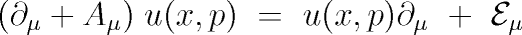

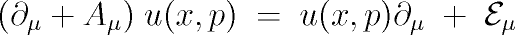

In [14]:
image = '84486adedc7ef22_basic.png'  # ab7fa88e04273c6_basic.png, f3a1a7bbee955b5_basic.png, 6f2db45aa26715f_basic.png, e761beeb988af86_basic.png, 659fcbc6df01643_basic.png
display(ipImage(filename=os.path.join(golden_image_dir, image), unconfined=True))
display(ipImage(filename=os.path.join(predicted_image_dir, image), unconfined=True))

In [15]:
Math(r'(\partial _{\mu }+A_{\mu })\; u(x,p)\=\u(x,p)\partial _{\mu }\+\{\cal E}_{\mu }')

<IPython.core.display.Math object>

In [18]:
df_test = pd.read_pickle('/zpool_3TB/i2l/data/dataset5/training_56/df_test.pkl')
df_test[['image', 'latex_ascii']]

,image,latex_ascii
63251,a85bc599a20418d_basic.png,\epsilon _ { z } = - \operatorname { l n } { \frac { \epsilon } { \mu } } + \sigma ( r _ { h } ) ~ ~ ~ .
116501,177e157fe42ffc9_basic.png,y \left( \begin{array} { c } { t _ { L } } \\ { b _ { L } } \\ \end{array} \right) _ { a } \epsilon _ { a b } \left( \begin{array} { c c } { H _ { 1 } ^ { 0 } } & { H _ { 2 } ^ { + } } \\ { H _ { 1 } ^ { - } } & { H _ { 2 } ^ { 0 } } \\ \end{array} \right) _ { b c } \left( \begin{array} { c } { - b _ { L } ^ { c } } \\ { t _ { L } ^ { c } } \\ \end{array} \right) _ { c }
95315,8bb2e039fc69e05_basic.png,"2 i ( U ^ { \mathrm { T } } W ) _ { I J } + ( U ^ { \mathrm { T } } V ) _ { I } { } ^ { K } \, F _ { K J } + F _ { I K } \, ( Z ^ { \mathrm { T } } W ) ^ { K } { } _ { J } - \textstyle { \frac { i } { 2 } } F _ { I K } \, ( Z ^ { \mathrm { T } } V ) ^ { K L } \, F _ { L J }"
40154,a401b23a82e37ad_basic.png,"\omega _ { \theta , \pm } ^ { ~ ~ ~ \mp } = \mp ~ \Delta ^ { 1 / 2 } , \; \; \omega _ { \phi , \pm } ^ { ~ ~ ~ \pm } = \mp ~ \imath \operatorname { c o s } { \theta } , \; \; \omega _ { \phi , \pm } ^ { ~ ~ ~ \mp } = \imath \operatorname { s i n } { \theta } \Delta ^ { 1 / 2 } ~ ."
74002,df5a862ae8a9f9a_basic.png,\Omega _ { 0 } = \Omega ( e = 0 ) \rightarrow \Omega = d p _ { a } \wedge d x ^ { a }
86270,e7201e86a4173eb_basic.png,"G _ { E } ^ { + } \left( x , x ^ { \prime } \right) = \left\langle E \right| \phi \left( x \right) \phi \left( x ^ { \prime } \right) \left| E \right\rangle = \frac { \Gamma \left( h _ { + } \right) \Gamma \left( h _ { - } \right) } { 1 6 \pi ^ { 2 } } F \left( h _ { + } , h _ { - } ; 2 ; \frac { 1 + P } { 2 } \right) ,"
112371,ba578f9bebfcf62_basic.png,"\chi = L ^ { 4 } \left[ \left\langle \Phi ^ { 2 } \right\rangle - \left\langle \Phi \right\rangle ^ { 2 } \right] \, ,"
147291,f359ad973c737f4_basic.png,1 6 \pi ^ { 2 } \frac { d } { d t } \operatorname { s i n } ^ { 2 } 2 \theta _ { 2 3 } = - 2 \operatorname { s i n } ^ { 2 } 2 \theta _ { 2 3 } \operatorname { c o s } ^ { 2 } \theta _ { 2 3 } ( h _ { \tau } - h _ { \mu } ) \frac { m _ { \nu 3 } + m _ { \nu 2 } } { m _ { \nu 3 } - m _ { \nu 2 } } .
39164,c38b6c84264afe9_basic.png,"P _ { R , L } ^ { 2 5 } = \frac { 1 } { \sqrt { 2 } } \bigg ( \frac { \sqrt { \alpha ^ { \prime } } } { R } n \mp \frac { R } { \sqrt { \alpha ^ { \prime } } } m \bigg ) ."
152589,0212e6e254bbedb_basic.png,C _ { \overline { { q } } q } ^ { f \neq f ^ { \prime } } ( Q ^ { 2 } ) = \frac { 1 } { Q ^ { 2 } } \biggl ( \frac { \alpha _ { s } } { \pi } \biggr ) ^ { 2 } C _ { F } T \biggl ( - \frac { 5 } { 4 } \biggr ) + O ( \alpha _ { s } ^ { 3 } )


In [19]:
df_test[df_test.image == '5762d68aeef4ae6_basic.png'].latex_ascii # 

138926    \mathsf { c ~ \approx ~ 2 ~ M ~ U _ { \mu 3 } ~ U _ { \tau 3 } } \equiv \mathsf { M ^ { \prime } } ; \; \; \mathsf { e ~ \approx ~ 2 ~ M ~ U _ { \mu 3 } ~ U _ { s 3 } } \equiv \mathsf { M ^ { \prime \prime \prime } } ; \; \; \mathsf { f ~ \approx ~ } \mathcal { O } ( \mathsf { m _ { 1 , 2 } } ) ,
Name: latex_ascii, dtype: object

In [21]:
Math(df_test[df_test.image == '5762d68aeef4ae6_basic.png'].latex_ascii.values[0])

<IPython.core.display.Math object>

In [31]:
for image in ['84486adedc7ef22_basic.png', 'ab7fa88e04273c6_basic.png', 'f3a1a7bbee955b5_basic.png', '6f2db45aa26715f_basic.png', 'e761beeb988af86_basic.png', '659fcbc6df01643_basic.png', 'ae462be70c31d9f_basic.png', '5762d68aeef4ae6_basic.png']:
    formula = df_test[df_test.image == image].latex_ascii.values[0]
#     print(formula)
    display(Math(formula))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [27]:
Math(df_strs.loc[8056].y.strip('$'))

<IPython.core.display.Math object>

In [28]:
df_strs.loc[8056].image_name

u'ae462be70c31d9f_basic.png'